In [1]:
import numpy as np
import os
from PIL import Image
import torch
import cv2
from torch.autograd import Variable
from SSD.data import BaseTransform,VOC_CLASSES as mapping
from SSD.ssd import build_ssd
import matplotlib.pyplot as plt
from keras.models import load_model

C:\Users\Dell\Desktop\Illegal_Parking


Using TensorFlow backend.


In [2]:
model=build_ssd('test')
model.load_state_dict(torch.load("SSD/ssd300_mAP_77.43_v2.pth",map_location=lambda storage,loc:storage))
transform=BaseTransform(model.size,(104/256.0,117/256.0,123/256.0))

cls=load_model("IP_model_1.h5")

C:\Users\Dell\Desktop\Illegal_Parking\SSD\ssd.py:33: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)
C:\Users\Dell\Desktop\Illegal_Parking\SSD\layers\modules\l2norm.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.weight,self.gamma)


In [3]:
def detect(frame , net , trans):
    height,width=frame.shape[:2]
    frame_t=trans(frame)[0]
    x=torch.from_numpy(frame_t).permute(2,0,1)      #rbg to grb
    x=Variable(x.unsqueeze(0))
    y=net(x)
    detectioins=y.data    #[batch,class,num_class,(score,x0,y0,x1,y1)]
    scale=torch.Tensor([width,height,width,height])
    i=7  #for cars
    num=0
    coor=[]
    labels=[]
    while detectioins[0,i,num,0]>=0.6 and mapping[i-1]=="car":
        points=detectioins[0,i,num,1:]
        points=points*scale
        points=points.numpy()
        num+=1
        coor.append(points)
    return (num,sorted(coor,key=lambda x : x[0]))

def pretransform(img ,coor):
    im=img.copy()
    return cv2.rectangle(im,(int(coor[0]),int(coor[1])),(int(coor[2]),int(coor[3])),(0,0,0),cv2.FILLED)

In [33]:
def show_details(img,data,preds):
    for i in range(data[0]):
        if(preds[0]==0):
            img=cv2.rectangle(img,(int(data[1][i][0]),int(data[1][i][1])),(int(data[1][i][2]),int(data[1][i][3])),(0,255,0),2)
        else:
            img=cv2.rectangle(img,(int(data[1][i][0]),int(data[1][i][1])),(int(data[1][i][2]),int(data[1][i][3])),(255,0,0),2)
    plt.imshow(img)
    
def predict_parking(image):
    img=image.copy()
    data=detect(frame=img,net=model,trans=transform)
    predictions=[]
    for num in range(data[0]):
        im=img.copy()
        im=pretransform(im,data[1][num])
        predictions.append(cls.predict([[img]]))
    return data,predictions

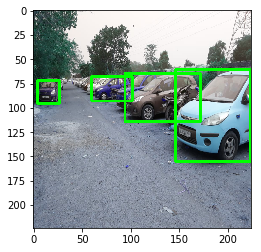

In [49]:
img=cv2.resize(cv2.imread("./Data/images/IMG-20190708-WA0011.jpg"),(224,224))

data,preds=predict_parking(img)

show_details(img,data,preds)